# 6. 나를 찾아줘 - Class Activation Map 만들기

**CAM, Grad-CAM을 위한 모델을 직접 만들고, CAM을 추출해 시각화 해본다. CAM을 Object detection에 적용해 결과를 평가해 본다.**

## 6-9. 프로젝트: CAM을 만들고 평가해 보자

---

### 목차

- 라이브러리 버전 확인하기
- CAM 구현하기
- Grad-CAM 구현하기
- 바운딩 박스 구하기
- IoU 구하기

---

### 라이브러리

- 라이브러리 가져오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
import PIL
from PIL import Image

print('슝=3')

슝=3


- GPU 연결 확인

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 데이터셋

- 데이터셋 불러오기
    - 데이터셋 [stanford_dogs](https://www.tensorflow.org/datasets/catalog/stanford_dogs)
        - 120 종의 개를 사진으로 판별하는 분류 문제 데이터셋
        - 라벨이 위치 정보인 바운딩 박스(bounding box) 정보 포함

In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
슝=3


- 데이터셋 features 확인
    - image: 입력 이미지 인덱스
    - label: 정답 클래스 인덱스
    - bbox
        - 바운딩 박스: 물체의 위치를 사각형 영역으로 표기하는 방법
        - BBoxFeature 타입
        - minmax 방식

In [4]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})


- 데이터셋 개수 확인
    - 12,000장의 학습용 데이터셋
    - 8,580장의 평가용 데이터셋

In [5]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))  # tf.Tensor(12000, shape=(), dtype=int64)
print(tf.data.experimental.cardinality(ds_test))  # tf.Tensor(8580, shape=(), dtype=int64)

tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)


- 데이터셋 클래스 개수 및 구성 확인

In [6]:
NUM_CLASSES = ds_info.features["label"].num_classes
NUM_CLASSES  # 120

120

In [7]:
ds_info.features["label"].names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

- 각 이미지 클래스와 인덱스 확인
    - 학습용 데이터셋 확인
    - 평가용 데이터셋 확인

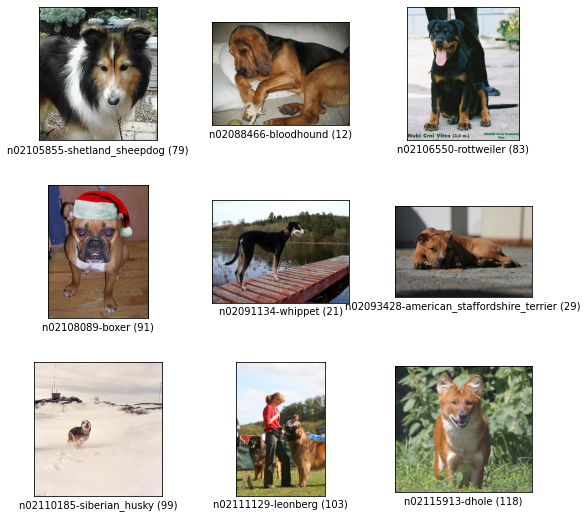

In [8]:
fig = tfds.show_examples(ds_train, ds_info)

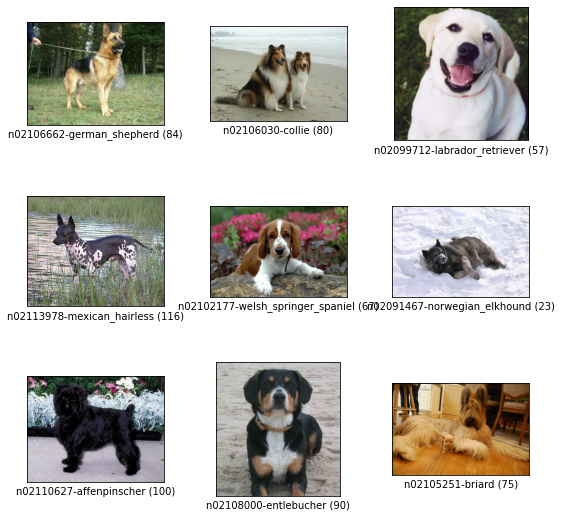

In [9]:
fig = tfds.show_examples(ds_test, ds_info)

In [10]:
ds_info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around
    the world. This dataset has been built using images and annotation from
    ImageNet for the task of fine-grained image categorization. There are
    20,580 images, out of which 12,000 are used for training and 8580 for
    testing. Class labels and bounding box annotations are provided
    for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='/aiffel/tensorflow_datasets/stanford_dogs/0.2.0',
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature

### 이미지 전처리

In [14]:
BATCH_SIZE = 16

- 학습 데이터와 검증 데이터에 normalizing 과 resizing 적용
    - 입력받은 이미지를 0~1 사이의 float32로 normalize
    - (224, 224) 사이즈로 resize

In [15]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

- 데이터 가공 함수
    - normalize, resize, shuffle 적용

In [16]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

- 데이터 가공

In [17]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test_norm = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


### CAM 구현하기

1) 이번 노드에 나왔던 CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.
2) 만든 함수로 CAM 이미지를 생성합시다.
3) 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요.
    - [webnautes님의 OpenCV Python 강좌 - 두 개의 이미지 더하기, 블렌딩](https://webnautes.tistory.com/1245)

- CAM 모델 구조
    - ResNet50 기반
    - pooling layer
    - softmax activation function
    - GAP

In [18]:
def create_cam_model():
    base_model = keras.applications.resnet50.ResNet50(
        include_top=False,    # Imagenet 분류기  fully connected layer 제거
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',      # GAP를 적용  
    )
    x = base_model.output
    preds = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

    cam_model = keras.Model(inputs=base_model.input, outputs=preds)
    return cam_model

In [19]:
cam_model = create_cam_model()
cam_model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________

In [20]:
EPOCHS = 30

In [21]:
def compile_and_fit(cam_model, epochs=2, batch_size=16):
    cam_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        metrics=['accuracy'],
    )

    history_cam_model = cam_model.fit(
        ds_train_norm,
        steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
        epochs=epochs,
        validation_data=ds_test_norm,
        verbose=1,
        use_multiprocessing=True,
    )

    return history_cam_model

In [22]:
history_cam_model = compile_and_fit(cam_model, EPOCHS, BATCH_SIZE)

Epoch 1/30
750/750 [==============================] - 178s 209ms/step - loss: 2.1784 - accuracy: 0.4513 - val_loss: 3.1520 - val_accuracy: 0.2317
Epoch 2/30
750/750 [==============================] - 155s 207ms/step - loss: 0.6930 - accuracy: 0.8118 - val_loss: 1.2495 - val_accuracy: 0.6402
Epoch 3/30
750/750 [==============================] - 155s 207ms/step - loss: 0.2238 - accuracy: 0.9536 - val_loss: 0.9584 - val_accuracy: 0.7209
Epoch 4/30
750/750 [==============================] - 155s 206ms/step - loss: 0.0651 - accuracy: 0.9931 - val_loss: 0.9061 - val_accuracy: 0.7430
Epoch 5/30
750/750 [==============================] - 155s 206ms/step - loss: 0.0275 - accuracy: 0.9992 - val_loss: 0.9449 - val_accuracy: 0.7403
Epoch 6/30
750/750 [==============================] - 155s 206ms/step - loss: 0.0178 - accuracy: 0.9997 - val_loss: 0.9227 - val_accuracy: 0.7465
Epoch 7/30
750/750 [==============================] - 155s 206ms/step - loss: 0.0129 - accuracy: 0.9998 - val_loss: 0.9405 -

- 학습 결과 시각화

In [26]:
def draw_history(history):
    plt.subplots(figsize=(12,4))

    # CAM Model Loss, Validation Loss 시각화
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title('CAM Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # CAM Model Accuracy, Validation Accuracy 시각화
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], 'r')
    plt.plot(history.history['val_accuracy'], 'b')
    plt.title('CAM Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

    plt.tight_layout()
    plt.savefig('CAM_Model_Result.png')  # 저장
    plt.show()

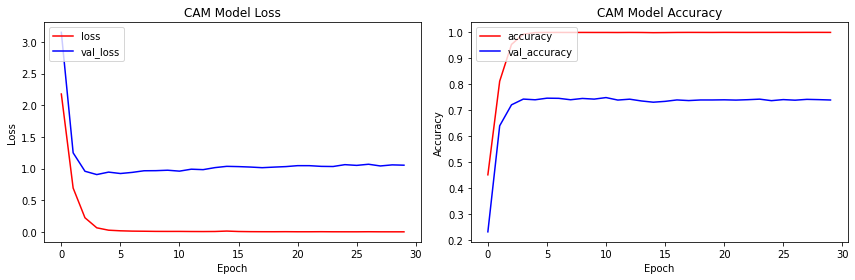

In [27]:
draw_history(history_cam_model)

- 학습한 모델 저장

In [28]:
CAM_MODEL_PATH = f'class_activation_map/data/my_cam_model_{EPOCHS}.h5'

In [29]:
cam_model.save(CAM_MODEL_PATH)
print("Save CAM Model")

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Save CAM Model


- 학습한 모델 불러오기

In [30]:
cam_model = tf.keras.models.load_model(CAM_MODEL_PATH)
print("Load CAM Model")

Load CAM Model


- CAM 반환 함수
    - CAM 생성에 필요한 3가지
        - 특성 맵
        - 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치,
        - 원하는 클래스의 출력값
    - model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환
    - conv_ouputs와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의
    - feedforward를 거친 후 CAM 계산
    - 입력 이미지의 크기에 맞춰 CAM resize
    - **CAM 의 Feature Map 은 conv5_block3_out 에서만 뽑을 수 있음**

In [38]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]  # 마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

- 데이터셋에서 한 장 뽑아서 이미지 확인하는 함수

In [39]:
def get_one(ds):
    ds = ds.shuffle(buffer_size=20000)
    
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    # print(label)
    return sample_data[0]

print('슝=3')

슝=3


- CAM 이미지와 원본 이미지 합치는 함수
    - 기존 lms 코드는 visualize_cam_on_image(src1, src2, alpha=0.5) 라는 함수를 사용했지만 사실상 cv2.addWeighted() 함수가 핵심이라서 굳이 저 함수를 사용하지 않고 내게 필요한 함수인 get_cam_image_3channel() 로 바꿔서 사용하기로 결정
    - 기존 lms 코드 그대로 cv2.addWeighted() 를 진행하면 cam_image 픽셀 값이 음수일 경우 얼룩진 것처럼 블렌딩되는 문제 발생 => 해결하기 위해 픽셀 값을 ReLU 처리(음수를 0으로 만듦) 했고 완전한 0~255 컬러 표현을 가능하게 만들었음 => 부드럽게 블렌딩됨!
    - alpha 값을 0.5 가 아니라 0.7 로 변경함 => 뽑아낸 CAM 이미지와 원본 이미지를 합성했을 때 CAM 이미지가 더 두드러지게 나타나도록 하기 위함

In [40]:
def get_cam_image_3channel(item, cam_image, alpha=0.7):
    origin_image = item['image'].astype(np.uint8)

    # - 문제: cam_image 픽셀 값이 음수일 경우 255 를 곱해봤자 음수가 되므로 cv2.addWeighted() 가 제대로 진행되지 않는다. => 음수인 부분만 얼룩진 것처럼 됨
    # - 해결: ReLU 처리(음수를 0으로 만듦)를 통해 완전한 0~255 컬러 표현이 가능해짐 => cv2.addWeighted() 를 했을 때 부드럽게 블렌딩됨!
    cam_image_3channel = np.stack(np.maximum([cam_image*255]*3,0), axis=-1).astype(np.uint8)

    # 기존 lms 코드에 있던 visualize_cam_on_image(src1, src2, alpha=0.5)과 동일한 기능
    blended_image = cv2.addWeighted(cam_image_3channel, alpha, origin_image, 1.0-alpha, 0.0)
    return blended_image

- 테스트 이미지, CAM 이미지, 테스트 이미지 + CAM 확인 함수

In [41]:
def draw_imgs(item, cam_image, blended_image, filename='CAM_Iamge.png'):
    plt.figure(figsize=(12,4))

    # 데이터셋에서 한 장 뽑아서 이미지 확인
    plt.subplot(1,3,1)
    plt.axis('off')
    plt.imshow(item['image'])

    # 얻어낸 CAM 이미지 확인
    plt.subplot(1,3,2)
    plt.axis('off')
    plt.imshow(cam_image)

    # CAM 이미지와 원본 이미지 합치기
    plt.subplot(1,3,3)
    plt.axis('off')
    plt.imshow(blended_image)

    plt.tight_layout()
    plt.savefig(f'{filename}')  # 저장
    plt.show()

- CAM 과 Grad CAM 비교를 위해 item 은 같은 이미지를 사용할 예정

In [42]:
item = get_one(ds_test)  # 데이터셋에서 이미지 한 장 뽑기

- CAM 결과 시각화
    - 테스트 이미지
    - CAM 이미지
    - 테스트 이미지 + CAM 이미지

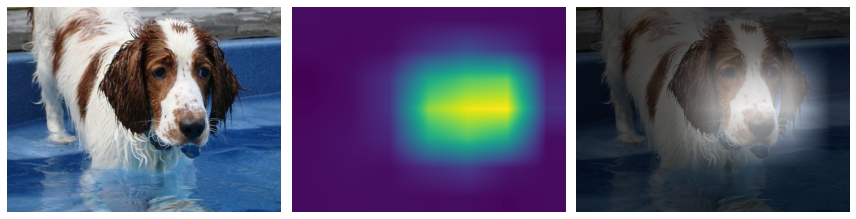

In [43]:
cam_image_1 = generate_cam(cam_model, item)  # CAM 이미지 얻기
blended_image_1 = get_cam_image_3channel(item, cam_image_1)  # CAM 이미지와 원본 이미지 합치기

draw_imgs(item, cam_image_1, blended_image_1, filename='CAM_Iamge_1.png')

### Grad-CAM 구현하기

1) 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

2) 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.

3) 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.

- Grad-CAM 반환 함수
    - cam_model을 그대로 활용
    - 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트 구해서 GAP 연산 적용 => 관찰 대상이 되는 레이어의 채널별 가중치를 구함
    - 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합해주어 cam_image를 얻음
    - 이전의 CAM 함수와 달리 **Grad-CAM 은 어떤 레이어든 CAM 이미지를 뽑아낼 수 있음** => 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 함
    - 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용

In [44]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

- Grad-CAM 결과 시각화
    - 테스트 이미지
    - CAM 이미지
    - 테스트 이미지 + CAM 이미지

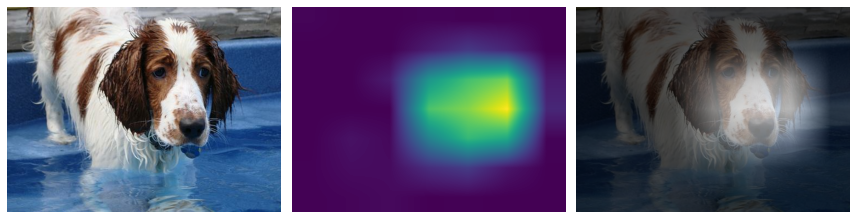

In [46]:
grad_cam_image_1 = generate_grad_cam(cam_model, 'conv5_block3_out', item)  # Grad-CAM 이미지 얻기
blended_image_2 = get_cam_image_3channel(item, grad_cam_image_1)  # CAM 이미지와 원본 이미지 합치기

draw_imgs(item, grad_cam_image_1, blended_image_2, filename='Grad_CAM_Iamge_1.png')

- Grad-CAM 전체 레이어 CAM 이미지 확인

In [47]:
# CAM model 레이어 이름 목록
CONV_NAMES = [
    'conv2_block1_out',
    'conv2_block2_out',
    'conv2_block3_out',
    'conv3_block1_out',
    'conv3_block2_out',
    'conv3_block3_out',
    'conv3_block4_out',
    'conv4_block1_out',
    'conv4_block2_out',
    'conv4_block3_out',
    'conv4_block4_out',
    'conv4_block5_out',
    'conv4_block6_out',
    'conv5_block1_out',
    'conv5_block2_out',
    'conv5_block3_out',
]

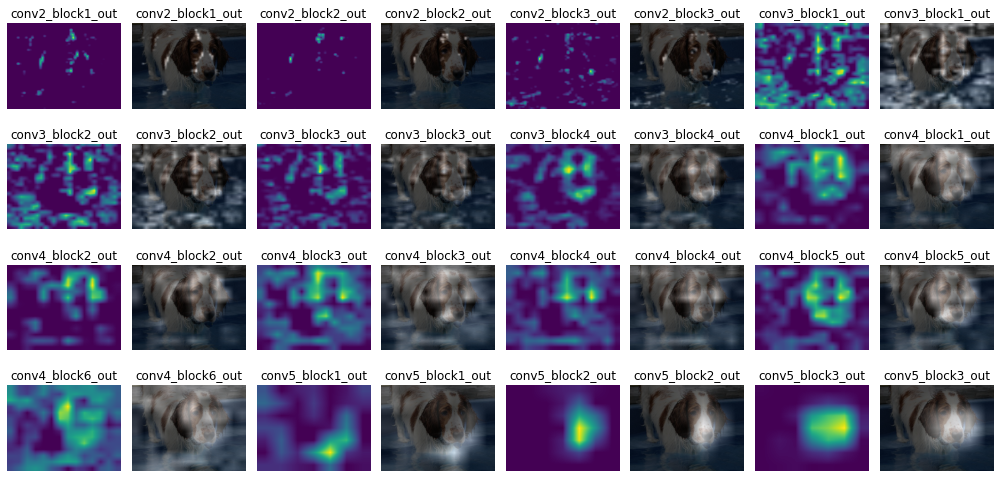

In [48]:
grad_cam_images = []
blended_images = []

len_ = len(CONV_NAMES)  # 16
cols = 8
rows = len_//cols * 2  # 두 개(feature map, 원본 + CAM)씩 보여줘야 하므로 *2를 함

plt.figure(figsize=(14,7))
j = 1
for i in range(len(CONV_NAMES)):
    grad_cam_image = generate_grad_cam(cam_model, CONV_NAMES[i], item)
    blended_image = get_cam_image_3channel(item, grad_cam_image)

    grad_cam_images.append(grad_cam_image)
    blended_images.append(blended_image)

    # draw
    plt.subplot(rows,cols,j)
    plt.axis('off')
    plt.title(CONV_NAMES[i])
    plt.imshow(grad_cam_image)
    j += 1

    plt.subplot(rows,cols,j)
    plt.axis('off')
    plt.title(CONV_NAMES[i])
    plt.imshow(blended_image)
    j += 1

plt.tight_layout()
plt.savefig('Grad_CAM_Images.png')  # 저장
plt.show()

### 바운딩 박스 구하기

1) 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

2) 1)에서 얻은 바운딩 박스를 시각화해 보세요.

- 바운딩 박스 생성 함수
    - score_thresh를 받아 역치값 이하의 바운딩 박스는 제거함
    - OpenCV의 findContours()와 minAreaRect()로 사각형 찾기 => rotated_rect 라는 회전된 바운딩 박스를 얻음
    - boxPoints()로 rotated_rect를 꼭지점으로 변경
    - int 자료형으로 변환

In [49]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('슝=3')

슝=3


- CAM 바운딩 박스 그리기
    - cam_image를 통해 bbox를 얻고 이미지 위에 시각화

In [50]:
rect_1 = get_bbox(cam_image_1)
rect_1

array([[134,  37],
       [499,  37],
       [499, 330],
       [134, 330]])

FileNotFoundError: [Errno 2] No such file or directory: 'result/CAM_Image_bbox.png'

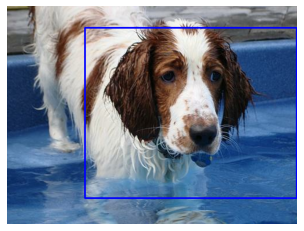

In [51]:
image_1 = copy.deepcopy(item['image'])
image_1 = cv2.drawContours(image_1, [rect_1], 0, (0,0,255), 2)
plt.axis('off')
plt.imshow(image_1)
plt.savefig('result/CAM_Image_bbox.png')  # 저장
plt.show()

- Grad-CAM 바운딩 박스 그리기
    - grad_cam_image를 통해 bbox를 얻고 이미지 위에 시각화

In [52]:
rect_2 = get_bbox(grad_cam_image_1)
rect_2

array([[140,  78],
       [472,   1],
       [538, 284],
       [205, 361]])

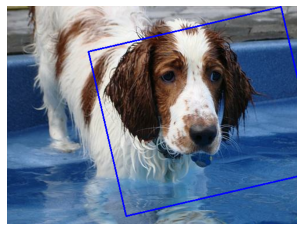

In [55]:
image_2 = copy.deepcopy(item['image'])
image_2 = cv2.drawContours(image_2, [rect_2], 0, (0,0,255), 2)
plt.axis('off')
plt.imshow(image_2)
plt.savefig('Grad_CAM_Image_bbox.png')  # 저장
plt.show()

- Grad-CAM 전체 레이어 바운딩 박스 그리기

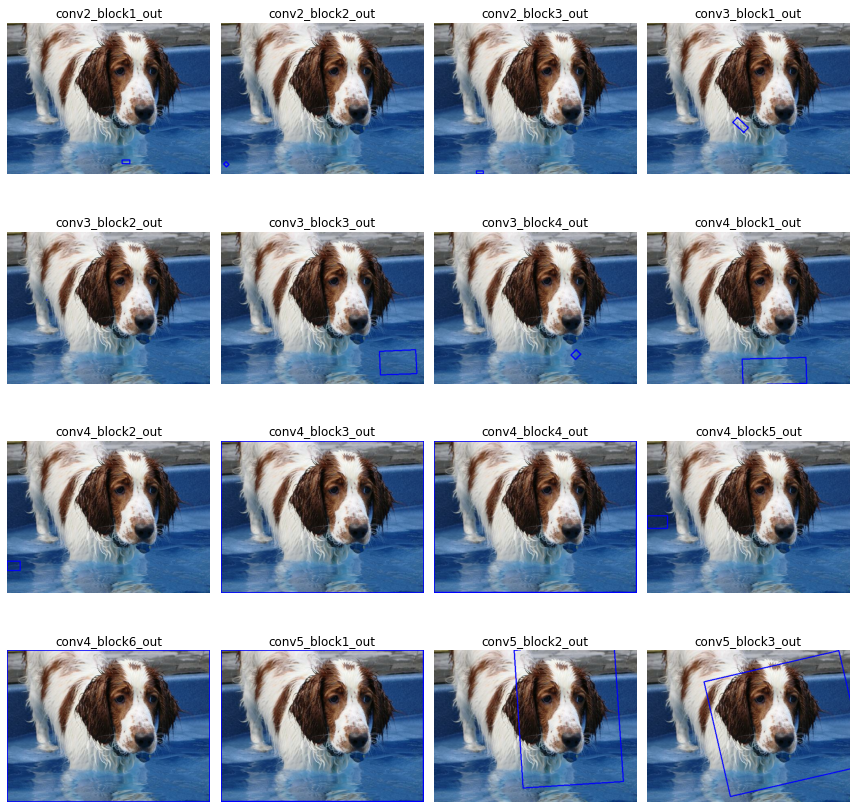

In [56]:
grad_cam_rects = []

len_ = len(CONV_NAMES)
cols = 4
rows = math.ceil(len_/cols)

plt.figure(figsize=(12,12))
for i, (grad_cam_image, conv_name) in enumerate(zip(grad_cam_images, CONV_NAMES)):
    rect = get_bbox(grad_cam_image)
    grad_cam_rects.append(rect)

    image = copy.deepcopy(item['image'])
    image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)

    # draw
    plt.subplot(rows,cols,i+1)
    plt.axis('off')
    plt.title(conv_name)
    plt.imshow(image)

plt.tight_layout()
plt.savefig('Grad_CAM_Images_bbox.png')  # 저장
plt.show()

### IoU 구하기

1) 정답 바운딩 박스(ground truth)와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.

2) CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.

- rect를 minmax bbox 형태로 치환하는 함수

In [58]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  # bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  # bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]),  # bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]),  # bounding box의 x_max
    ]
    return bbox

print('슝=3')

슝=3


- IoU 계산 함수
    - gt_bbox: 정답 바운딩 박스(ground truth)
    - pred_bbox: 예측값 바운딩 박스(prediction box)

In [59]:
def get_iou(pred_bbox, gt_bbox):
    y_min = max(pred_bbox[0], gt_bbox[0])
    x_min= max(pred_bbox[1], gt_bbox[1])
    y_max = min(pred_bbox[2], gt_bbox[2])
    x_max = min(pred_bbox[3], gt_bbox[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    pred_bboxArea = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    gt_bboxArea = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    iou = interArea / float(pred_bboxArea + gt_bboxArea - interArea)

    return iou

print('슝=3')

슝=3


- CAM IoU 구하기
    - rect를 minmax bbox 형태로 치환
    - 데이터의 ground truth bbox 확인
    - IoU 계산

In [60]:
pred_bbox_1 = rect_to_minmax(rect_1, item['image'])
pred_bbox_1

[0.09866666666666667, 0.268, 0.88, 0.998]

In [61]:
item['objects']['bbox']

array([[0.   , 0.066, 0.8  , 0.89 ]], dtype=float32)

In [62]:
cam_iou = round(get_iou(pred_bbox_1, item['objects']['bbox'][0]),4)
cam_iou

0.5499

- Grad-CAM IoU 구하기
    - rect를 minmax bbox 형태로 치환
    - 데이터의 ground truth bbox 확인
    - IoU 계산

In [63]:
pred_bbox_2 = rect_to_minmax(rect_2, item['image'])
pred_bbox_2

[0.0026666666666666666, 0.28, 0.9626666666666667, 1.076]

In [64]:
item['objects']['bbox']

array([[0.   , 0.066, 0.8  , 0.89 ]], dtype=float32)

In [65]:
get_iou(pred_bbox_2, item['objects']['bbox'][0])

0.5190824349715424

- Grad-CAM 전체 레이어 IoU 확인

In [66]:
grad_cam_iou_dict = {}
for i, (rect, conv_name) in enumerate(zip(grad_cam_rects, CONV_NAMES)):
    pred_bbox = rect_to_minmax(rect, item['image'])
    iou = get_iou(pred_bbox, item['objects']['bbox'][0])
    grad_cam_iou_dict[conv_name] = round(iou,4)
    print(f'* {conv_name}의 IoU 계산 결과: {grad_cam_iou_dict[conv_name]}')

* conv2_block1_out의 IoU 계산 결과: 0.0
* conv2_block2_out의 IoU 계산 결과: 0.0
* conv2_block3_out의 IoU 계산 결과: 0.0
* conv3_block1_out의 IoU 계산 결과: 0.0114
* conv3_block2_out의 IoU 계산 결과: 0.0
* conv3_block3_out의 IoU 계산 결과: 0.0043
* conv3_block4_out의 IoU 계산 결과: 0.0019
* conv4_block1_out의 IoU 계산 결과: 0.0
* conv4_block2_out의 IoU 계산 결과: 0.0
* conv4_block3_out의 IoU 계산 결과: 0.6623
* conv4_block4_out의 IoU 계산 결과: 0.6654
* conv4_block5_out의 IoU 계산 결과: 0.0042
* conv4_block6_out의 IoU 계산 결과: 0.6623
* conv5_block1_out의 IoU 계산 결과: 0.6654
* conv5_block2_out의 IoU 계산 결과: 0.5142
* conv5_block3_out의 IoU 계산 결과: 0.5191


- IoU 결과 데이터 프레임으로 저장

In [67]:
# CAM 의 Feature Map 은 Grad-CAM 과 다르게 conv5_block3_out 에서만 뽑을 수 있으므로 나머지 레이어 IoU 값은 NaN 입력
cam_iou_dict = {}
for conv_name in CONV_NAMES:
    cam_iou_dict[conv_name] = cam_iou if conv_name == 'conv5_block3_out' else np.nan

In [68]:
iou_result = {
    'CAM IoU': cam_iou_dict,
    'Grad-CAM IoU': grad_cam_iou_dict
}

df_iou = pd.DataFrame(iou_result)
df_iou

,CAM IoU,Grad-CAM IoU
conv2_block1_out,NaN,0.0000
conv2_block2_out,NaN,0.0000
conv2_block3_out,NaN,0.0000
conv3_block1_out,NaN,0.0114
conv3_block2_out,NaN,0.0000
conv3_block3_out,NaN,0.0043
conv3_block4_out,NaN,0.0019
conv4_block1_out,NaN,0.0000
conv4_block2_out,NaN,0.0000
conv4_block3_out,NaN,0.6623


In [69]:
conv5_block3_out_iou = df_iou.loc['conv5_block3_out']
conv5_block3_out_iou

CAM IoU         0.5499
Grad-CAM IoU    0.5191
Name: conv5_block3_out, dtype: float64

---

### 결과 정리

#### CAM Model 학습 결과 시각화

![](result/CAM_Model_Result.png)

기존 lms 코드에서 Epochs=2 로 설정한 이유를 알 수 있다. validation loss 와 validation accracy 를 보면 에폭 2 를 기점으로 성능 향상이 이루어지지 않는 것을 알 수 있다. 혹시나 하는 마음에 에폭을 높여봤지만 소용없었다. early stopping 을 걸면 시간이 덜 걸렸으리란 생각이 들었다.

#### Grad-CAM 모든 레이어 결과

Grad-CAM 은 CAM 에 비해 모델에 대한 제약이 없고 모든 레이어의 Feature Map 을 시각화할 수 있는 장점이 있어서 모든 레이어의 특징맵과 바운딩 박스 시각화 및 IoU 계산을 진행해봤다.

- Grad-CAM 모든 레이어 특징맵/바운딩박스 시각화

||All Layers of Grad-CAM|
|:---:|:---:|
|CAM img|![](result/Grad_CAM_Images.png)|
|CAM bbox|![](result/Grad_CAM_Images_bbox.png)|

- Grad-CAM 모든 레이어 IoU 결과

In [70]:
# 모든 레이어
df_iou

,CAM IoU,Grad-CAM IoU
conv2_block1_out,NaN,0.0000
conv2_block2_out,NaN,0.0000
conv2_block3_out,NaN,0.0000
conv3_block1_out,NaN,0.0114
conv3_block2_out,NaN,0.0000
conv3_block3_out,NaN,0.0043
conv3_block4_out,NaN,0.0019
conv4_block1_out,NaN,0.0000
conv4_block2_out,NaN,0.0000
conv4_block3_out,NaN,0.6623


#### conv5_block3_out 결과 비교

CAM 은 마지막 레이어(conv5_block3_out)에서만 특징맵을 추출할 수 있대서 Grad-CAM 의 마지막 레이어(conv5_block3_out)에서 추출한 특징맵과 비교할 수 있게 따로 정리했다.

- conv5_block3_out 특징맵/바운딩박스 시각화 비교

||CAM|Grad-CAM|
|:---:|:---:|:---:|
|CAM img|![](result/CAM_Iamge_1.png)|![](result/Grad_CAM_Iamge_1.png)|
|CAM bbox|![](result/CAM_Image_bbox.png)|![](result/Grad_CAM_Image_bbox.png)|

- conv5_block3_out 의 IoU 결과 비교

In [71]:
# conv5_block3_out 의 IoU 만 비교
conv5_block3_out_iou

CAM IoU         0.5499
Grad-CAM IoU    0.5191
Name: conv5_block3_out, dtype: float64

- 결론
    - 캠 모델 학습 횟수를 늘려봤자 성능 향상에 효과가 있지 않았다.
    - 테스트 데이터에 따라 결과가 천차만별이다. **특징맵 시각화를 여러 번 돌려본 결과 대부분 CAM 이 Grad-CAM 보다 훨씬 안정적으로 특징을 잘 찾아냈다.** 지금 올리는 결과는 Grad-CAM 의 결과가 더 좋게 나온 것이다.
    - Grad-CAM 의 IoU 만 따졌을 때에도 오히려 CAM 보다 낮게 나올 때가 많았다. => 그만큼 특징을 안정적으로 찾지 못한다고 볼 수 있다.

---

# 회고
